# 프로젝트: SentencePiece 사용하기

### 라이브러리 버전 확인

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.22.2
3.4.3
0.5.2


## 1. 데이터 불러오기

### Import

In [2]:
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f1b582655b0>)

In [4]:
naver_df = pd.read_table('ratings.txt')
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [5]:
print('데이터 개수 :', len(naver_df))

데이터 개수 : 200000


**결측치, 중복 확인 및 제거**

In [6]:
origin_len = len(naver_df)

In [7]:
naver_df.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [8]:
naver_df = naver_df.dropna(how='any')
print(naver_df.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[199992 rows x 3 columns]>


In [9]:
print('결측치 제거 후 데이터 개수 :', len(naver_df))  

결측치 제거 후 데이터 개수 : 199992


In [10]:
cleaned_corpus = naver_df.drop_duplicates(['document'])   

In [11]:
print('중복 제거 후 데이터 개수 :', len(cleaned_corpus))

중복 제거 후 데이터 개수 : 194543


In [12]:
print('전처리 전 데이터 개수 :', origin_len)
print('전처리 후 데이터 개수 :', len(cleaned_corpus)) 
print('전처리 후 남은 데이터 양(%)', (len(cleaned_corpus)/origin_len)*100)

전처리 전 데이터 개수 : 200000
전처리 후 데이터 개수 : 194543
전처리 후 남은 데이터 양(%) 97.2715


In [13]:
cleaned_corpus.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


**데이터 분석 및 전처리**

In [14]:
naver_review = cleaned_corpus['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/tmp/ipykernel_1131/1743548021.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


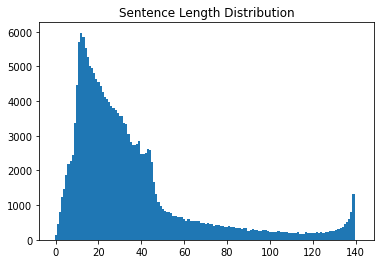

In [15]:
min_len = 999
max_len = 0
sum_len = 0

for sen in naver_review:
    length = len(sen)
    if min_len > length: 
        min_len = length
        
    if max_len < length: 
        max_len = length
    
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(naver_review))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in naver_review:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

최장길이 142에 가까운 데이터가 많은 것을 볼 수 있다.

In [16]:
# 어떤문장인지 확인해보기
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return 

check_sentence_with_length(naver_review, 135)

내가 남자라그런가 이거 겁나 긴장감있고 흥미진진하던데..ㄷㄷ 나만그런가워낙에 격투씬을 좋아해서.ㅋㅋㅋ 그냥 아무생각없이 집에서 스마트티비로 봐서 재밌었나봄 이거 뭔영화인지도 모르고 암살에 나온 이정재 있길래 걍봄 ㅋㅋ 하여튼 너무 재밌게 봤음
줄리아 로버츠의 웃음은 정말 보는 사람을 기쁘게 해준다. 웃음 하나로 기쁨과 슬픔을 표현할 수 있는 배우..전통을 깨고 여성의 새로운 삶을 살으라고 영화는 보여주는 데 영화에서는 전통을 완전히 벗어나야 한다는 것만을 강조하는 것 같아 아쉽다.
평점 왜 이렇게 낮아요??? 영화 대박인데...진짜....ㅋㅋㅋ 와.. 어떻게 이런상상을 해서 이런 영화를... 대박대박.. ㅠ 생각지못한 반전.. 처음엔 반신반의하면서 봤는데.. 최고내요...ㄷㄷㄷ 근데 금발 여주는 중반에 좀 짜증나긴했음ㅋ
큰 기대 안하고 띄엄띄엄 보다가 집중해서 봤네요!! 저는 잘봤습니다. 액션도 뛰어나고 아슬아슬한 장면들을 극복해 가는게 나름 잼있었어요!! 마지막에 여자 박사가 살았는지 죽었는지가 안나와서 좀 아쉽네요..그래도 딸은 살렸으니 다행스럽다는 ㅎㅎ
누군가는 잃고, 누군가는 벌고, 또 누군가는 죽는 게임. 그리고 끊임없이 반복되는 삶과 기억의 굴레. 하지만 시작할 때부터 영화는 이미 심각했고, 지루했다. 다 본 후 생각해보니 그럴 수밖에 없었겠다 싶다. 넓고 얕은 재미, 길고 깊은 여운.
영화내용은 사실별거 없지만 보고나면 생각을 많이하게 되는 영화임. 재미있기도 하고, 결론은 무엇이냐 하면 빨갱이들이 아무것도 모르는 사람들 선동해서 비참한 결과를 낳게 한다는 내용임. 복수심에 불타는 이북출신들도 나오는데 다 역사적인 사실임.
고등학교때 보고 지금에서 생각난 영화 참~그땐 눈물 콧물 흘리면서 봤는데짐 보면 나올라나.. 하긴 세월이 많이 흘렀지 아마 짐 시대하곤 스토리자체가 뻔하니깐 하지만 지금도 잊혀지지않는장면은 주인공이 공부하는장면과하늘도 갈라놓지 못한 그들의사랑
오스카는 흔히 볼수있는 아들이자 장난끼 많은 오빠 그리고 항상 미안해하는 남편. 감정이

In [17]:
# sentence_length[문장 길이] = 갯수 
# idx = 문장길이 , _sum = 해당 문장 길이인 문장의 개수 

for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 135 초과하는 문장 길이를 추출합니다.
    if _sum > 135:
        print("Outlier Index:", idx+1)

Outlier Index: 2
Outlier Index: 3
Outlier Index: 4
Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47
Outlier Index: 48
Outlier Index: 49
Outlier Index: 50
Outlier Index: 51
Outlier Index: 52
Outlier Index: 53
Outlier Index: 54
Outlier Index: 55
Outlier Index: 56
Outlier Index: 57


In [18]:
# 문장길이 10이하의 문장 확인해보기
check_sentence_with_length(naver_review, 3)

재밌다
가연세
재밋다
야마켄
재밌음
좋아요
괜찮네
화려함
좋은데
짱~~
재밋음
굿..
킹왕짱
재밌어
까까~
진짜다
재밌당
명작.
잼있다
재미다
재미짐
몽정기
최고다
각키♥
수작.
참재미
채고야
베리굳
김은미
굿!!
갑이다
구여움
좋구나
행~복
10점
ㅎ최고
재밌군
멋지당
최고임
똥파리
잘봤음
...
조아요
하하하
굿굿굿
훌륭함
재미닷
재밋당
좋ㅎ음
쩐다;
ㅋㅋㅋ
개코미
화이팅
잼네요
귀여움
으리!
좋다.
팬심♥
볼만함
감동적
감동임
감동~
패닝짱
목두기
괜찬네
재미씀
좋네요
참좋다
동감.
ㅋ재미
재밋쪼
한석규
재밌긔
웃긴데
감동!
ㅎㄷㄷ
아프다
대단함
걸작.
람보3
명작!
나의꿈
잼겟따
신선함
갱호~
재밌네
대박!
^-^
연출력
오ㅓㅏ
재및음
굿 ㅋ
오호호
괜찮음
드라마
zzz
최고!
감동함
짱짱맨
구구굿
멋있다


In [19]:
check_sentence_with_length(naver_review, 7)

정말 재밌다~
sf 의 명작
나는 살아간다
아름다운 곡들
엄청 웃기다.
돌아온 싱하형
완전 짱!!!
배두나씨좋아요
나름 재밌었음
지연누나완전짱
최고의 엔딩씬
정말 최고다.
진짜 짱이야!
not bad
연극으로 봤음
잼있어요...
오 마이 숄더
잘 만들었네요
최고의영화!ㅋ
ㅋㅋㅋ 차태현
죽이네 캬..
최고의 영화.
아름다운 영화
그래도 ㅋㅋㅋ
유덕화가 좋다
정말 죽인다!
멋있다 ㅎㅎㅎ
절라게 재밌다
실제로보고와서
신선한 감동!
봉선이 쨩 !
또 보고싶다♥
재밌다 ㅈ밌어
zzzz재밌네
난 독보여야지
최고의 드라마
감동적이네요.
이중이 김소연
초딩한텐 최고
역시 다이하드
핵에환장하는.
고다미 괜찮음
두말하면귀찮죠
괜찮던데...
참! 죠아용.
아주 좋아요.
좋아하는 영화
수작이 었다.
완벽한 드라마
제목이 뭐이래
재미는 있다.
넘넘 잼어요~
ㅎ 좀 웃기네
최고였다...
재미있어요!!
배우가아까울뿐
연걸사마♥_♥
재밌던데...
시리즈중 최고
잘 만들었어요
이태민 화이팅
....ㅠㅡㅜ
잼나잼나!!!
ㅋㅋ그냥재밌음
또다른감동이다
재밌게 봤어요
재미있음~~~
명작중의 명작
hmr33신고
재밌었는데..
특별한 재능.
최고 ,,ㅋㅋ
콩그레츄레이숀
좋은영화입니다
후덜덜3등~!
나만 볼순없다
매혹적인 영화
이유없이10점
재미있는영화~
로망은 어디에
좋다....!
...하균앓이
만점짜리지 뭐
최고의 액션씬
흥미진진!!!
그럭저럭...
너무 좋아..
So good
감동적이에요.
너무 젬 없음
무삭제버전 굿
박중훈 최고!
만화도 보자.
재밌어요!!ㅎ
.......
좀 재미잇엇다
괜찮은 드라마
짐캐리 예스!
열린 결말이라
GooD!~~
유쾌한 영화.


In [20]:
check_sentence_with_length(naver_review, 9)

이스트우드 최고작
썩 괜찮았던 영화
거의 10점 짜리
흥미로운 전기영화
치즈루 귀여워 ㅠ
ㅋㅋ올만에 웃었다
꽤 재밋네요!^^
좋았다 정말...
신비롭고 아름답다
총의 포스가...
존경받을만 하다.
다시 올리기 ㄱㄱ
정말 최고의 영화
김수로 너무 좋아
그것 엄청재밋는디
최고의 드라마..
첫사랑이 생각난다
최고내요 색달라요
나만 재밋게 봤나
재미있어요.ㅋㅋㅋ
이이 러브 나루토
최고의드라마~~ㅋ
개봉은 17일인데
정말 재밋다 쿨럭
잼나요......
개.쩌.는.영.화
역시 아메리칸파이
짱재밌음 꼭 보셈
감동 ㅠㅠ....
진짜재밋어요ㅋㅋㅋ
보기 좋았던 영화
다시 보고 싶다.
정려원 최고다,,
넌GAMEOVER
미실, 비담 최고
미친 사랑 이야기
너무재밌어요 강추
내 인생의 작품!
수고많으셨습니다.
송승헌걍짜응...
이런영화좋다...
나의 영원한 로망
눈이호강하네여ㅎㅎ
전 재밌는데용..
3보다 재밌는데?
충주성심 파이팅!
에단때문에 10점
재밌어요재밌어ㅜㅜ
울면서 봤어영..
한마디로 굳!!!
진짜 재미있어요.
봉묨ㅂ모몽모뭄ㅇㄷ
다들 죽지 말아라
1편만큼 재밌다.
잘만든 드라마 ㅎ
경탁이 최고~!!
그냥 말이필요없다
아빠! 힘내세요~
아주 웃겼습니다.
조미 넘 이뻐 ㅋ
그냥 평점 오르기
이보희의 아름다움
이건흥행해야된다.
액션신이너무좋았다
짱짱 진짜멋잇어요
감동적인 전기영화
음... 재밌었다
부시는 나쁜 쉐리
brilliant
블랙코미디의 진수
이해와 배려사이.
당시 최고의 영화
..하하,....
!!!대박 ㅇㅅㅇ
송강호 개쩌네ㅋㅋ
재밌고 감동있어요
나카야마 시노부♥
진짜 짱인거 같아
짱 재밌어요 ㅋㅋ
느낌 괜찮은 영화
난 재밌었음 :D
정말 순수한 영화
무성영화, 불꽃,
감동, 스릴, 굿
올해 최고의 영화
따뜻한 애니메이션
정말 따뜻한 영화
박예진 예뻐 예뻐
예술영화의 완성작
그냥눈물이나왔다.
희망은 좋은것이다
멕라이언 짱귀여워
난 무서웠음...
완전 재미있음 ~
엑스파일메니아라면
존나 웃겨 ㅋㅋㅋ
..정말 쩔어요.
좀비영화중 왕중왕
지금봐도 대단ㅎㅎ
정말 이쁜 드라마


In [21]:
check_sentence_with_length(naver_review, 4)

ㅇㅋㅇㅋ
재밌당!
쨩ㅎㅎㅎ
섬세하다
재미잇다
재밋는데
좋은영화
완전추천
구하라♥
최고였지
강인구속
질질싼다
Good
강풀 짱
대작이다
귀여워.
베리굿~
우...
3.14
재밌네-
행복수행
good
디게웃겨
최고!~
GOOD
대박 쩜
재미있다
의리다.
재밌있다
짱이야요
벽속에서
좋습니다
짱bbb
웃긴영화
멋진영화
조정석♥
멋집니다
멋진걸!
진짜 짱
재밌네요
좋아좋아
재밌다.
시대정신
잼있네요
아름답다
짱이쁘요
멋져부러
잼났어요
멋있다!
감동영화
재미잇음
재밌었던
좋아요.
좋다~!
재밋어옂
재미있음
짱...
굿이군요
재밌었다
최고였다
재밋네요
ㅋㅋ 굿
재밋어요
최고!!
재밋엇음
연장 고
명작이다
쩐다!!
알이즈웰
좋은데.
최고다.
최고 ㅋ
눈물난다
즐겁다.
베리 굿
평점관리
cool
괜찮아.
원더풀.
쩔어요ㅎ
아...
보고싶다
멀까..
훌륭했다
8.6점
짱!!♡
베뤼~굿
재밌어요
휴잭맨짱
...굿
평점조절
잼있었다
최고 ㅎ
걸작이다
괜찬네여
재밌었음
짱이에요
잼있어요
볼만하다
잼있따!
재밌는데


Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/tmp/ipykernel_1131/4241797388.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


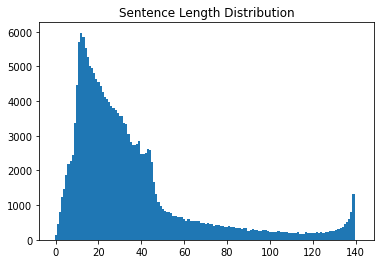

In [22]:
min_len = 999
max_len = 0
sum_len = 0

# cleaned_corpus = list(set(naver_review))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(naver_review)) 

for sen in naver_review:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in naver_review:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 최적의 max_len 찾기

In [23]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [24]:
below_threshold_len(36, naver_review)  # 평균
below_threshold_len(140, naver_review)  # 최장 
below_threshold_len(70, naver_review)  # 중앙값
below_threshold_len(50, naver_review)  
below_threshold_len(60, naver_review)  

전체 샘플 중 길이가 36 이하인 샘플의 비율: 66.08616090016089
전체 샘플 중 길이가 140 이하인 샘플의 비율: 99.99948597482305
전체 샘플 중 길이가 70 이하인 샘플의 비율: 88.66523082300571
전체 샘플 중 길이가 50 이하인 샘플의 비율: 82.05640912291884
전체 샘플 중 길이가 60 이하인 샘플의 비율: 85.86739178484962


/tmp/ipykernel_1131/2227199284.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


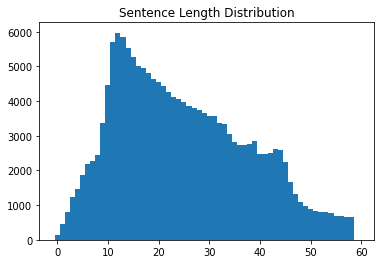

In [25]:
# 문장길이 <=100으로 처리

max_len = 60   
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.

filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len)]

# 1. 내가 짰지만 비효율적인 코드 
filtered_corpus = [] 
filtered_label = []  
for row, label in zip(naver_df['document'], naver_df['label']):    
    if (len(row) < max_len):     
        filtered_corpus.append(row)  
        filtered_label.append(label)   
        
# 2. 같이 공부하는 @수희님이 알려주신 코드 
# 데이터프레임 조건부 슬라이싱 
# str.len() 두 함수에 대해 알 수 있었다. 
train_data = cleaned_corpus[cleaned_corpus['document'].str.len() < max_len]   



# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [26]:
sentence_length

array([ 124,  460,  793, 1222, 1469, 1882, 2187, 2270, 2440, 3379, 4459,
       5711, 5970, 5848, 5518, 5265, 5005, 4947, 4806, 4626, 4542, 4436,
       4264, 4129, 4073, 3973, 3865, 3809, 3743, 3665, 3561, 3566, 3353,
       3339, 3036, 2831, 2736, 2736, 2775, 2856, 2486, 2486, 2495, 2625,
       2599, 2257, 1660, 1311, 1079,  968,  893,  844,  799,  789,  765,
        678,  686,  654,  658,    0])

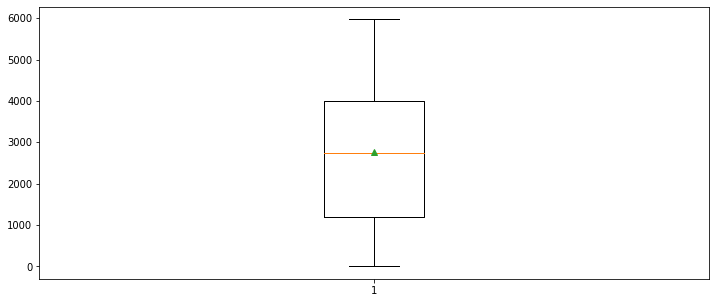

In [27]:
plt.figure(figsize=(12,5))
plt.boxplot([sentence_length], showmeans=True)
plt.show()

In [28]:
print('전처리 전 데이터 개수 :', len(naver_df))
print('전처리 후 데이터 개수 :', len(train_data))
print('전처리 후 남은 데이터 양(%)', (len(train_data)/len(naver_df))*100)

전처리 전 데이터 개수 : 199992
전처리 후 데이터 개수 : 166401
전처리 후 남은 데이터 양(%) 83.20382815312612


# 2. sentencePiece 모델 학습

In [29]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 375162 Mar 22 02:06 korean_spm.model
-rw-r--r-- 1 root root 144497 Mar 22 02:06 korean_spm.vocab


In [30]:
!ls -l kor_spm_unigram_8k*
!ls -l kor_spm_unigram_4k*
!ls -l kor_spm_bpe_8k*
!ls -l kor_spm_bpe_16k*

-rw-r--r-- 1 root root 375096 Mar 19 05:55 kor_spm_unigram_8k.model
-rw-r--r-- 1 root root 144435 Mar 19 05:55 kor_spm_unigram_8k.vocab
ls: cannot access 'kor_spm_unigram_4k*': No such file or directory
-rw-r--r-- 1 root root 370378 Mar 19 05:56 kor_spm_bpe_8k.model
-rw-r--r-- 1 root root 115580 Mar 19 05:56 kor_spm_bpe_8k.vocab
-rw-r--r-- 1 root root 523017 Mar 19 06:04 kor_spm_bpe_16k.model
-rw-r--r-- 1 root root 258215 Mar 19 06:04 kor_spm_bpe_16k.vocab


In [31]:
# 학습된 subwords 확인

vocab_list = pd.read_csv('kor_spm_unigram_8k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.27463
4,.,-3.47852
5,..,-4.24637
6,▁영화,-4.42651
7,이,-4.44480
8,...,-4.48456
9,가,-4.71341


In [32]:
print('subword의 개수 :', len(vocab_list))
vocab_list.sample(10)

subword의 개수 : 8000


,0,1
5835,▁아예,-10.59080
4927,팍,-10.35250
7096,라이브,-10.99620
6397,▁좋았을텐데,-10.76210
881,i,-8.59205
1326,럽,-8.99167
1948,쯤,-9.34944
6115,▁재미나게,-10.67580
468,겠다,-8.05292
6374,▁자극적인,-10.75730


### SentencePiece 성능 비교평가

* vocab size = 8k, 16k
* model type = unigram, bpe
* kor_spm_unigram_8k
* kor_spm_unigram_16k
* kor_spm_bpe_8k
* kor_spm_bpe_16k

In [33]:
def test_performance(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [34]:
print('kor_spm_unigram_8k')
test_performance(model='kor_spm_unigram_8k.model')

# # unigram은 오류가 나서 학습이 되지 않았다. 
# print('kor_spm_unigram_4k')
# test_performance(model='kor_spm_unigram_4k.model')

print('kor_spm_bpe_8k')
test_performance(model='kor_spm_bpe_8k.model')

print('kor_spm_bpe_16k')
test_performance(model='kor_spm_bpe_16k.model')

kor_spm_unigram_8k
[1653, 9, 464, 16, 1383, 9, 158, 15, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bpe_8k
[6043, 990, 6533, 6257, 1506, 6252, 6360, 6246, 6244]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bpe_16k
[9096, 12780, 1506, 14252, 11430, 14244]
['▁아버지가', '방에', '들어', '가', '신다', '.']
아버지가방에들어가신다.


# 3. Tokenizer 함수 작성

* 훈련시킨 SentencePiece를 활용해 tokenizer역할을 하는 함수를 정의합니다.


* 함수의 조건

    1.매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.
    
    2.생성된 vocab 파일을 읽어와 { \ : \ } 형태를 가지는 word_index 사전과 { \ : \} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.
    
    3.리턴값인 tensor는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding

In [35]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./{}.vocab".format(spm), 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [36]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()
# s.Load('kor_spm_bpe_16k.model')  # lstm 학습시 오류

s.Load('kor_spm_unigram_8k.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'kor_spm_unigram_8k')           
print(tensor)
# print(word_index)
# print(index_word)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  517 3252
    14 1097 2572    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1592 2168  228  544    9
   280 7921  756    8]]


# lstm으로 감정분석 모델 학습

* SentencePiece 토크나이저가 적용된 모델을 학습 후 수렴하는 것을 확인합니다.
* SentencePiece 토크나이저 성능 평가

In [37]:
tensor, word_index, index_word = sp_tokenize(s, train_data['document'], 'kor_spm_unigram_8k')

In [38]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(train_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [39]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

106496 26624 33281
106496 26624 33281


In [40]:
from tensorflow.keras.initializers import Constant

vocab_size = vocab_size
word_vector_dim = 32  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim,
                                    ))
            
model_LSTM.add(keras.layers.LSTM(128))
# model_LSTM.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [41]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [42]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=es,
                    verbose=1)

Epoch 1/20
1664/1664 [==============================] - 220s 130ms/step - loss: 0.4049 - accuracy: 0.8139 - val_loss: 0.3506 - val_accuracy: 0.8444
Epoch 2/20
1664/1664 [==============================] - 217s 130ms/step - loss: 0.3188 - accuracy: 0.8615 - val_loss: 0.3365 - val_accuracy: 0.8514
Epoch 3/20
1664/1664 [==============================] - 216s 130ms/step - loss: 0.2822 - accuracy: 0.8778 - val_loss: 0.3365 - val_accuracy: 0.8524
Epoch 4/20
1664/1664 [==============================] - 214s 128ms/step - loss: 0.2536 - accuracy: 0.8915 - val_loss: 0.3481 - val_accuracy: 0.8490
Epoch 5/20
1664/1664 [==============================] - 213s 128ms/step - loss: 0.2268 - accuracy: 0.9049 - val_loss: 0.3705 - val_accuracy: 0.8493
Epoch 6/20
1664/1664 [==============================] - 215s 129ms/step - loss: 0.1994 - accuracy: 0.9169 - val_loss: 0.3856 - val_accuracy: 0.8406
Epoch 00006: early stopping


In [43]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
print(results)

832/832 - 24s - loss: 0.3950 - accuracy: 0.8404
[0.3949909508228302, 0.8403695821762085]


# 5. 모델 성능 비교 평가

비교 대상
* LSTM의 input x_data를 토크나이징한 SentencePiece 모델
* LSTM모델의 Word_vector_dimension

In [44]:
def performance_test_spm(spm_model, vocab_size, word_vector_dim):
    s = spm.SentencePieceProcessor()
    s.Load("{}.model".format(spm_model)) 
    
    tensor, word_index, index_word = sp_tokenize(s, train_data['document'], spm_model)
    
    x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    

    model_LSTM = keras.Sequential()
    model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                     word_vector_dim,
                                        ))

    model_LSTM.add(keras.layers.LSTM(128))
    model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model_LSTM.summary()
    
    model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
    epochs=10
    batch_size=64
    
#     es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    
    history_LSTM = model_LSTM.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val,y_val),
                        callbacks=[es],
                        verbose=1)
    
    results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
    print(results)
    
    return history_LSTM

In [45]:
history_unigram_8k_dim_8 = performance_test_spm('kor_spm_unigram_8k', vocab_size, word_vector_dim=8)
history_unigram_8k_dim_64 = performance_test_spm('kor_spm_unigram_8k', vocab_size, word_vector_dim=64)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           64000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1664/1664 [==============================] - 200s 120ms/step - loss: 0.4129 - accuracy: 0.8071 - val_loss: 0.3668 - val_accuracy: 0.8419
Epoch 2/10
1664/1664 [==============================] - 203s 122ms/step - loss: 0.3324 - accuracy: 0.8572 - val_loss: 0.3487 - val_accuracy: 0.8468
Epoch 3/10
1664/1664 [==============================] - 201s 121ms/step - loss: 0.

In [46]:
history_bpe_8k_dim_8 = performance_test_spm('kor_spm_bpe_8k', vocab_size, word_vector_dim=8)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 8)           64000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1664/1664 [==============================] - 202s 121ms/step - loss: 0.4154 - accuracy: 0.8076 - val_loss: 0.3621 - val_accuracy: 0.8423
Epoch 2/10
1664/1664 [==============================] - 200s 120ms/step - loss: 0.3352 - accuracy: 0.8549 - val_loss: 0.3515 - val_accuracy: 0.8461
Epoch 3/10
1664/1664 [==============================] - 201s 121ms/step - loss: 0.

In [47]:
history_bpe_8k_dim_8 = performance_test_spm('kor_spm_bpe_8k', vocab_size, word_vector_dim=8)
history_bpe_16k_dim_64 = performance_test_spm('kor_spm_bpe_8k', vocab_size, word_vector_dim=64)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 8)           64000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1664/1664 [==============================] - 202s 120ms/step - loss: 0.4473 - accuracy: 0.7892 - val_loss: 0.3658 - val_accuracy: 0.8413
Epoch 2/10
1664/1664 [==============================] - 198s 119ms/step - loss: 0.3347 - accuracy: 0.8561 - val_loss: 0.3579 - val_accuracy: 0.8444
Epoch 3/10
1664/1664 [==============================] - 199s 120ms/step - loss: 0.

**학습 과정 평가**

In [48]:
def visualize_train(train_history, param):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

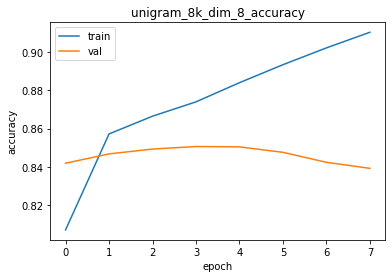

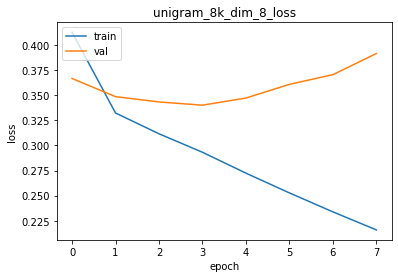

In [49]:
visualize_train(history_unigram_8k_dim_8, param='unigram_8k_dim_8')

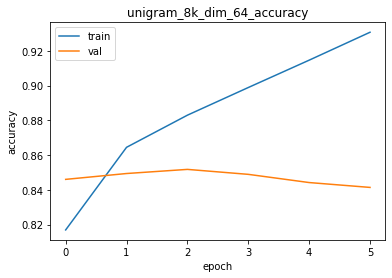

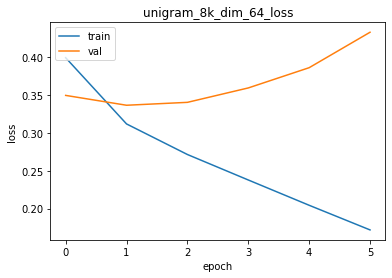

In [50]:
visualize_train(history_unigram_8k_dim_64, param='unigram_8k_dim_64')

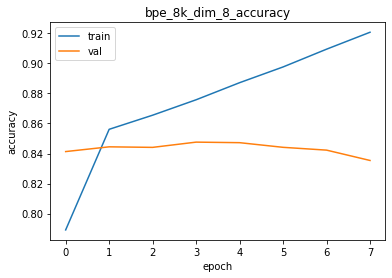

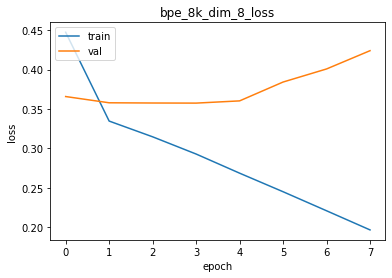

In [51]:
visualize_train(history_bpe_8k_dim_8, param='bpe_8k_dim_8')

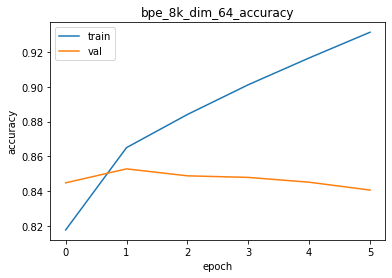

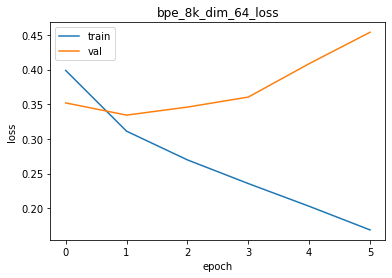

In [52]:
visualize_train(history_bpe_16k_dim_64, param='bpe_8k_dim_64')

# [GD-02] 회고

처음에 과제의 취지를 잘못 이해해서 지난번에 했던 익스를 가져와야 하나 싶었는데, 준서님의 도움으로 옳은 방향으로 나아갈 수 있었습니다.
그래도 헷갈리고 어려운건 매한가지였네요😂

이번 노드도 혼자서 해결하지 못해 다른 분의 깃허브를 참고했습니다.
https://github.com/miinkang/AI_Project_AIFFEL

데이터 분석을 하고 문장을 확인하는 부분까지는 어찌저찌 해결해냈는데, 늘 모델학습에서 꼬여서 구글링이 필수네요ㅎㅎ

Sentence Piece 모델을 학습하는 것은 모델을 가져오는 코드는 노드에 있는 것을 가져왔고 학습된 subword를 확인했는데요.
성능을 비교평가 하는 과정에서 유니그램에 오류가 나서 위에 언급했듯이 구글링을 했는데, 다른 분도 오류가 나는 곳이 비슷비슷 하더라고요.

한국어가 자연어 처리 하는 것이 힘들다는 말이 노드에 계속 언급이 되었기 때문에 알고는 있었지만, 늘 생각 이상으로 어렵더라고요.
노드를 여러번 읽어서 차츰차츰 이해가 되는 것 처럼 한국어 자연어 처리도 그렇게 되었으면 좋겠다는 이런 이상한 생각을 하게 만들더라구요😅

아직까지 모호하고 이해가 안 되는 부분이 몇 개 있지만 노드를 통해서 복습하고, 구글링을 통해 자료를 찾다보면 언젠가는 이해가 되겠죠?
뭔가 할 거는 많은데 정리가 잘 안 되는 부분이 많아서 큰일이네요.